# Analyze the results given by NAS

## Build the network given by NAS 

In [1]:
import sys
sys.path.append('..')
sys.path.append('../..')


import iterative_naive_nas

from sklearn.model_selection import train_test_split

#import os
#os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 

import tensorflow as tf

tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

import numpy as np

import custom_training

import utils.losses_utils as losses

import utils.data_utils as data_utils

import utils.viz_utils as viz

import matplotlib.pyplot as plt

import matplotlib.animation as animation


#50_partitions
#optimized_parameters = [8.50071696e-04, 3.55273289e-01, 3.86577994e-01, 9.51559796e-01,
# 1.00000000e+00, 1.60000000e+01, 1.57000000e+03]
#30_paritions
#optimized_parameters = [3.46661820e-04, 4.01120020e-01, 9.09580986e-01, 4.13090818e-01,
# 3.93104672e-01, 8.00000000e+00, 8.20000000e+02]
#25_partitions
#optimized_parameters = [6.80863834e-04, 4.68269339e-01, 4.51964628e-01, 1.80029101e-01,
# 3.94141219e-01, 2.00000000e+00, 7.20000000e+02]
#25_partitions_downsampled_3_absolute_zfmri
#optimized_parameters = [2.70884979e-04, 5.85912076e-01, 7.90651030e-01, 6.76594653e-01, 2.93054361e-01, 6.40000000e+01, 4.95000000e+03]
#25_partitions_downsampled_3_absolute_zfmri_dataset_02
optimized_parameters = [3.13730152e-05, 2.25510169e-01, 1.00000000e+00, 1.00000000e+00, 6.39733694e-01, 6.40000000e+01, 2.80000000e+03]
#25_partitions_downsampled_4_absolute_zfmri
#optimized_parameters = [5.38778274e-04, 1.00000000e+00, 1.00000000e-04, 1.00000000e-04, 0.00000000e+00, 2.00000000e+00, 2.20000000e+03]
#21_partitions
#optimized_parameters = [1.0e-14, 1.0e-04, 1.0e+00, 1.0e-04, 0.0e+00, 1.6e+01, 8.2e+02]
#21_partitions_tanh
#optimized_parameters = [6.70771985e-04, 3.71587509e-01, 6.03183109e-01, 8.71381868e-01,
#                        3.22005780e-01, 2.00000000e+00, 1.82000000e+03]

learning_rate = float(optimized_parameters[0])
l1_penalization_eeg = float(optimized_parameters[1])
l1_penalization_bold = float(optimized_parameters[2])
l1_penalization_decoder = float(optimized_parameters[3])
loss_coefficient = float(optimized_parameters[4])
batch_size = int(optimized_parameters[5])
current_shape = int(optimized_parameters[6])
#eeg_hidden_shape = int(optimized_parameters[6])
#bold_hidden_shape = int(optimized_parameters[7])
#decoder_hidden_shape = int(optimized_parameters[8])

bold_shift=3
f_resample=1.8
n_partitions=25
by_partitions=False
partition_length=14
fmri_resolution_factor=3
mutate_bands=False
activation=''
dataset="02"

if(dataset=="01"):
    n_individuals=10
elif(dataset=="02"):
    n_individuals=14

if(activation):
    eeg_file='../../optimized_nets/eeg/eeg_' + str(n_partitions) + '_partitions' + '_' + activation + '.json'
    bold_file='../../optimized_nets/bold/bold_' + str(n_partitions) + '_partitions' + '_' + activation + '.json'
    decoder_file='../../optimized_nets/decoder/decoder_' + str(n_partitions) + '_partitions' + '_' + activation + '.json'
    
else:
    if(dataset=="01"):
        eeg_file='../../optimized_nets/eeg/eeg_' + str(n_partitions) + '_partitions_downsampled_' + str(fmri_resolution_factor) + '_absolute_zfmri.json'
        bold_file='../../optimized_nets/bold/bold_' + str(n_partitions) + '_partitions_downsampled_' + str(fmri_resolution_factor) + '_absolute_zfmri.json'
        decoder_file='../../optimized_nets/decoder/decoder_' + str(n_partitions) + '_partitions_downsampled_' + str(fmri_resolution_factor) + '_absolute_zfmri.json'
    elif(dataset=="02"):
        eeg_file='../../optimized_nets/eeg/eeg_' + str(n_partitions) + '_partitions_downsampled_' + str(fmri_resolution_factor) + '_absolute_zfmri_dataset_'+ dataset + '.json'
        bold_file='../../optimized_nets/bold/bold_' + str(n_partitions) + '_partitions_downsampled_' + str(fmri_resolution_factor) + '_absolute_zfmri_dataset_'+ dataset + '.json'
        decoder_file='../../optimized_nets/decoder/decoder_' + str(n_partitions) + '_partitions_downsampled_' + str(fmri_resolution_factor) + '_absolute_zfmri_dataset_'+ dataset + '.json'
    

gpus=tf.config.list_physical_devices('GPU')
if(len(gpus)):
    tf.config.experimental.set_virtual_device_configuration(gpus[0], 
                                                            [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=1024)])

Starting to Load Data
(170, 882)
(170, 882)
(170, 882)
(170, 882)
(170, 882)
(170, 882)
(170, 882)
(170, 882)
(170, 882)
(170, 882)
(170, 882)
(170, 882)
(170, 882)
(170, 882)
(196, 49, 111, 14)
(196, 882, 14)
Finished Loading Data
Pairs Created


In [2]:
eeg_train, bold_train, mask, scalers = data_utils.load_data(list(range(n_individuals)),#n_voxels=n_voxels, 
                                                            bold_shift=bold_shift, 
                                                            n_partitions=n_partitions, 
                                                            by_partitions=by_partitions, 
                                                            partition_length=partition_length, 
                                                            f_resample=f_resample, 
                                                            mutate_bands=False,
                                                            fmri_resolution_factor=fmri_resolution_factor,
                                                            standardize_eeg=True, 
                                                            standardize_fmri=True,
                                                            dataset=dataset)

n_partitions=bold_train.shape[0]//bold_train.shape[2]
n_voxels = bold_train.shape[1]
interval_length = bold_train.shape[2]

eeg_train = eeg_train.reshape(eeg_train.shape+(1,))
bold_train = bold_train.reshape(bold_train.shape+(1,))

print("Finished Loading Data")

(170, 882)
(170, 882)
(170, 882)
(170, 882)
(170, 882)
(170, 882)
(170, 882)
(170, 882)
(170, 882)
(170, 882)
(170, 882)
(170, 882)
(170, 882)
(170, 882)
(196, 49, 111, 14)
(196, 882, 14)
Finished Loading Data


In [3]:
if(dataset=="01"):
    n_individuals_train=8
    n_individuals_test=2

    eeg_val = eeg_train[n_individuals_train*n_partitions:n_individuals_train*n_partitions+n_individuals_test*n_partitions]
    eeg_train = eeg_train[:n_individuals_train*n_partitions]
    bold_val = bold_train[n_individuals_train*n_partitions:n_individuals_train*n_partitions+n_individuals_test*n_partitions]
    bold_train = bold_train[:n_individuals_train*n_partitions]
elif(dataset=="02"):
    n_individuals_train=10
    n_individuals_test=4

    eeg_val = eeg_train[n_individuals_train*n_partitions:n_individuals_train*n_partitions+n_individuals_test*n_partitions]
    eeg_train = eeg_train[:n_individuals_train*n_partitions]
    bold_val = bold_train[n_individuals_train*n_partitions:n_individuals_train*n_partitions+n_individuals_test*n_partitions]
    bold_train = bold_train[:n_individuals_train*n_partitions]

In [4]:
min_train = np.amin(bold_train)
min_val = np.amin(bold_val)

print(min_train, min_val)

max_value = np.amin([min_train, min_val])

print(max_value)

#bold_train = bold_train - max_value+0.001
#bold_test = bold_test - max_value+0.001

#bold_train = np.log(bold_train)
#bold_test = np.log(bold_test)

-7.6383952851410495 -11.848368328323696
-11.848368328323696


In [5]:
eeg_train = eeg_train.astype('float32')
bold_train = bold_train.astype('float32')

eeg_val = eeg_val.astype('float32')
bold_val = bold_val.astype('float32')

eeg_test = None
bold_test = None

In [6]:
X_train_eeg, X_train_bold, tr_y, X_bold_train_target = data_utils.create_eeg_bold_pairs(eeg_train, bold_train, instances_per_individual=n_partitions)
X_val_eeg, X_val_bold, tv_y, X_bold_val_target = data_utils.create_eeg_bold_pairs(eeg_val, bold_val, instances_per_individual=n_partitions)

tr_y = np.array(tr_y, dtype='float32')
tv_y = np.array(tv_y, dtype='float32')

<IPython.core.display.Javascript object>


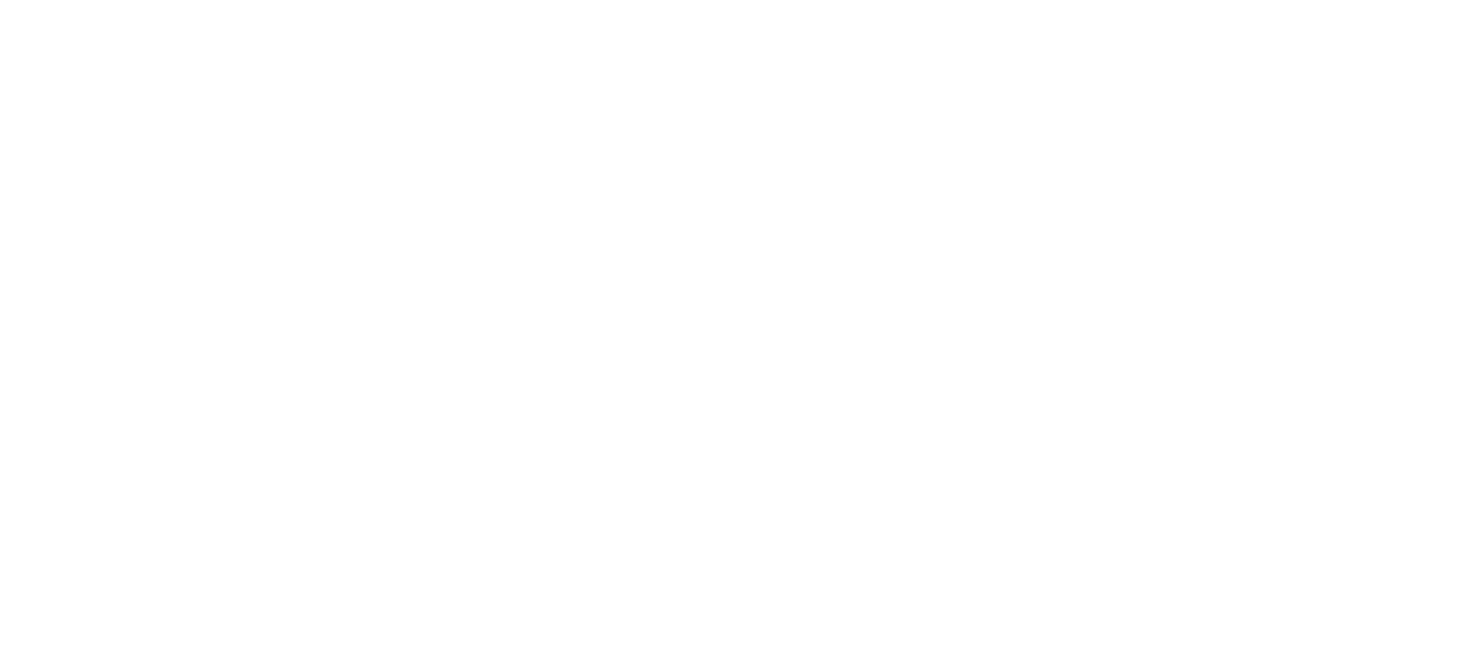

RuntimeError: Requested MovieWriter (ffmpeg) not available

In [60]:
from numpy.linalg import norm

%matplotlib notebook

individual=0
normalize=False

real_mapping = np.copy(bold_train[individual,:, :, 0])
synth_mapping = np.copy(decoder_network(eeg_network(eeg_train)).numpy()[individual,:, :, 0])

if(normalize):
    for voxel in range(len(real_mapping[individual])):
        real_mapping[individual][voxel] = real_mapping[individual][voxel]/norm(real_mapping[individual][voxel])            
        synth_mapping[individual][voxel] = synth_mapping[individual][voxel]/norm(synth_mapping[individual][voxel])

n_frames = real_mapping.shape[1]

fig, axes = plt.subplots(1,2, figsize=(9,4))
ax1, ax2 = axes

ims1 = []
ims2 = []

for frame in range(n_frames):
    im1 = ax1.imshow(np.resize(real_mapping[:,frame], (50, 52)), 
                     cmap='gnuplot2', interpolation='nearest', animated=True)
    im2 = ax2.imshow(np.resize(synth_mapping[:,frame], (50, 52)), 
                     cmap='gnuplot2', interpolation='nearest', animated=True)
    ims1.append([im1])
    ims2.append([im2])

ani1 = animation.ArtistAnimation(fig, ims1, interval=500, blit=True, repeat_delay=1000)
ani2 = animation.ArtistAnimation(fig, ims2, interval=500, blit=True, repeat_delay=1000)

ani1_html= open("ani1.html","w")
ani1_html.write(ani1.to_html5_video())
ani1_html.close()

In [13]:
from utils import fmri_utils, viz_utils

import importlib
importlib.reload(viz_utils)

for individual in range(2):
    for timestep in range(14):

        synthesized = decoder_network(eeg_network(eeg_val)).numpy()[individual*n_partitions+timestep]
        synthesized = synthesized.reshape((1,)+synthesized.shape[:-1])
        bold_instance=bold_val[individual*n_partitions+timestep]
        bold_instance=bold_instance.reshape((1,)+bold_instance.shape[:-1])

        synth_vmin=np.amin(synthesized+np.abs(np.amin(synthesized))+0.1)
        synth_vmax=np.amax(synthesized+np.abs(np.amin(synthesized))+0.1)
        print(synth_vmin, synth_vmax)
        real_vmin=np.amin(bold_instance+np.abs(np.amin(bold_instance))+0.1)
        real_vmax=np.amax(bold_instance+np.abs(np.amin(bold_instance))+0.1)

        synthesized_nifti_images = fmri_utils.get_nifti_from_set(synthesized+np.abs(np.amin(synthesized))+0.1, 
                                                              mask.mask_img_)
        real_nifti_images = fmri_utils.get_nifti_from_set(bold_instance+np.abs(np.amin(bold_instance))+0.1, 
                                                                                 mask.mask_img_)

        viz_utils.plot_view_mask(synthesized_nifti_images[0], 
                                timestep=timestep, 
                                vmin=synth_vmin,
                                vmax=synth_vmax,
                                symmetric_cmap=False,
                                resampling_factor=fmri_resolution_factor,
                                save_file="../../results/tmp/02/plot_synthesized_test_"+str(individual)+"_"+str(timestep)+"_"+mode+".html")
        viz_utils.plot_view_mask(real_nifti_images[0], 
                                timestep=timestep, 
                                vmin=real_vmin,
                                vmax=real_vmax,
                                symmetric_cmap=False,
                                resampling_factor=fmri_resolution_factor,
                                save_file="../../results/tmp/02/plot_real_"+str(individual)+"_"+str(timestep)+".html")

0.10213802 0.11415253
0.1 0.114505745
0.10136113 0.11453406
0.1 0.11446462
0.10069428 0.111556806
0.1 0.11311481
0.1 0.114214815
0.1 0.11442552
0.10019169 0.11319188
0.1 0.11203609
0.1 0.11421362
0.1 0.1175187
0.1 0.1114736
0.1 0.11800394
0.1 0.112200536
0.1 0.11843691
0.1 0.1152669
0.1 0.11949102
0.1 0.11889807
0.1 0.11395035
0.10102985 0.11193184
0.1 0.1149408
0.1 0.11253492
0.1 0.11636136
0.1 0.113573946
0.1 0.115200974
0.1 0.11313323
0.100058295 0.11386619


### Train the network

In [7]:
import importlib
importlib.reload(custom_training)
importlib.reload(losses)

eeg_network, bold_network, decoder_network = viz.get_models_and_shapes(eeg_file=eeg_file, 
                                                                      bold_file=bold_file, 
                                                                      decoder_file=decoder_file)
    
eeg_input_shape = (eeg_train.shape[1], eeg_train.shape[2], eeg_train.shape[3], eeg_train.shape[4])
bold_input_shape=(bold_train.shape[1], bold_train.shape[2], bold_train.shape[3])

mode="lstm_zeeg_zfmri"
multi_modal_model = custom_training.multi_modal_network(eeg_input_shape, bold_input_shape, eeg_network, bold_network, 
                                                        corr_distance=True,
                                                        dist_function=losses.mean_volume_abs,#mean_volume_abs/euclidean /kl_loss
                                                        lstm=True,
                                                        gan=False,
                                                        gan_activation="softmax",
                                                        gan_output_dimension=1)

validation_loss = custom_training.linear_combination_training(X_train_eeg, 
                                                            X_train_bold, 
                                                            tr_y, 
                                                            eeg_network,
                                                            decoder_network, 
                                                            multi_modal_model, 
                                                            epochs=5, 
                                                            encoder_optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
                                                            decoder_optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
                                                            batch_size=batch_size, 
                                                            loss_function=losses.get_reconstruction_euclidean_volume_loss,
                                                            #linear_combination=loss_coefficient,
                                                            linear_combination=1.0,
                                                            clip_value_gradient=25.0, 
                                                            clip_value_loss=np.inf, 
                                                            margin_constrastive=1.0,#for lstm better 0.8
                                                            X_val_eeg=X_val_eeg,
                                                            X_val_bold=X_val_bold,
                                                            tv_y=tv_y,
                                                            eeg_train=eeg_train, 
                                                            bold_train=bold_train, 
                                                            eeg_val=eeg_val, 
                                                            bold_val=bold_val,
                                                            X_bold_train_target=X_bold_train_target,
                                                            X_bold_val_target=X_bold_val_target,
                                                            verbose=False)

model_name = "LComb"

Encoder Loss:  0.29903838  || Decoder Loss:  16.593441 Validation Decoder Loss:  31.335157
Encoder Loss:  0.12792455  || Decoder Loss:  14.830951 Validation Decoder Loss:  30.890041
Encoder Loss:  0.16429925  || Decoder Loss:  14.787965 Validation Decoder Loss:  30.88465
Encoder Loss:  0.08244763  || Decoder Loss:  14.787719 Validation Decoder Loss:  30.885574
Encoder Loss:  0.09504776  || Decoder Loss:  14.787887 Validation Decoder Loss:  30.886097


train set mean:  -0.03822331743348124
train set std:  0.03573336974815686
test set mean:  -0.03081093137422743
test set std:  0.03436670791298804


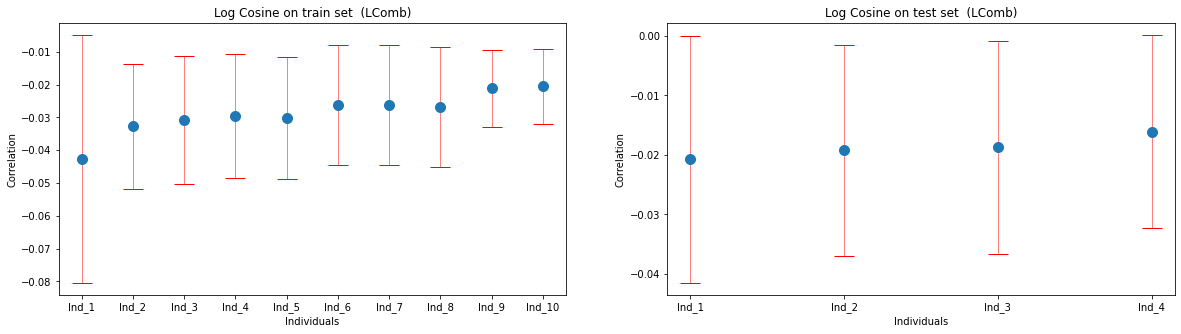

train set mean:  nan
train set std:  nan
test set mean:  nan
test set std:  nan


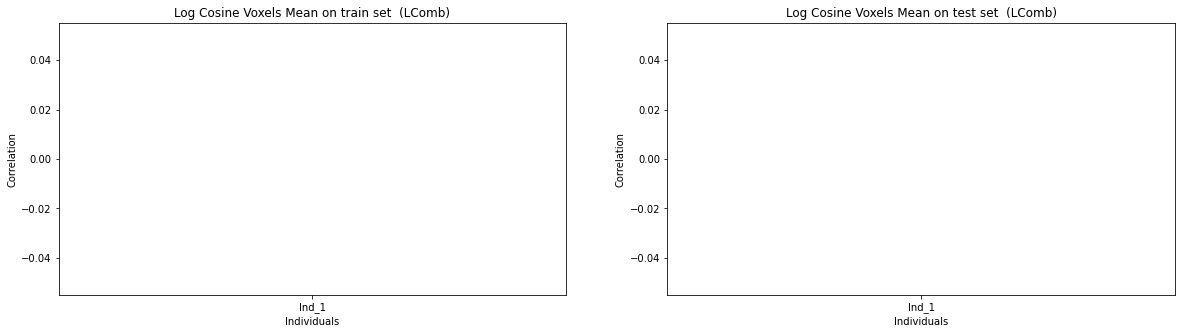

train set mean:  -0.03690094013597575
train set std:  0.03329302957737746
test set mean:  -0.02978683805953811
test set std:  0.03175988248125978


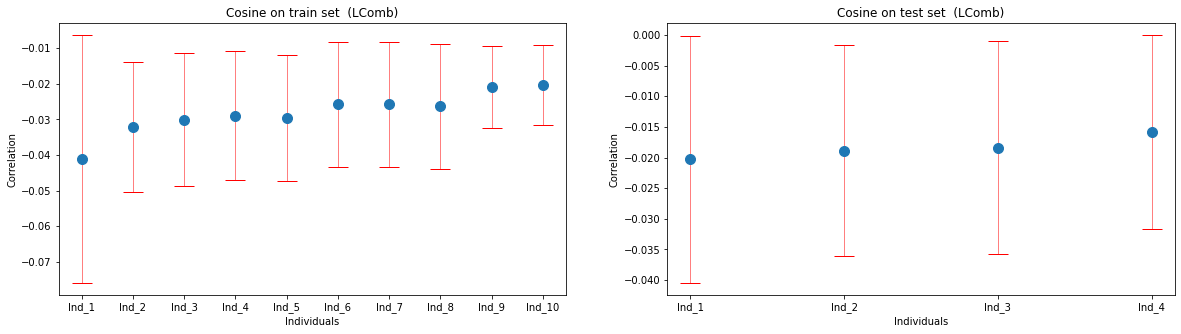

train set mean:  nan
train set std:  nan
test set mean:  -inf
test set std:  nan


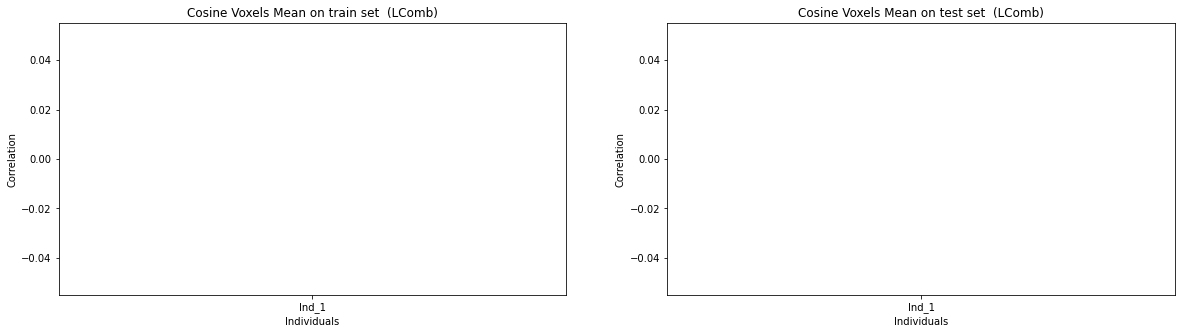

train set mean:  110.48775896344866
train set std:  5.374779154935174
test set mean:  110.50343350001744
test set std:  5.095809261151977


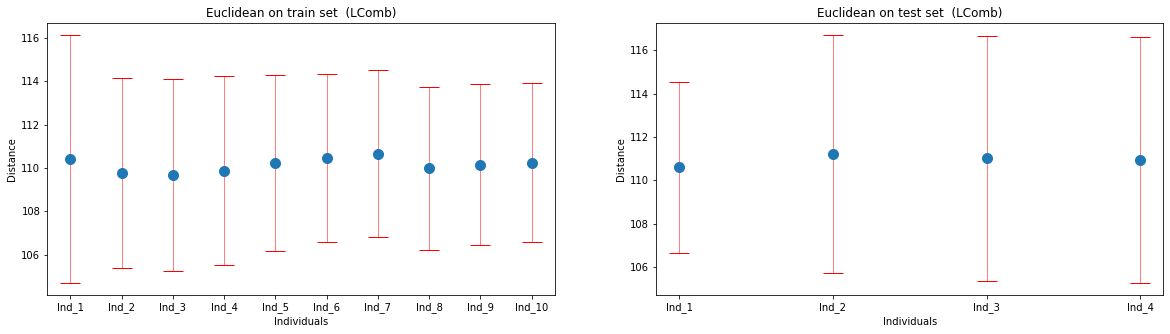

train set mean:  29.48480991636004
train set std:  1.3937329282214244
test set mean:  29.489240850721085
test set std:  1.3215453429603243


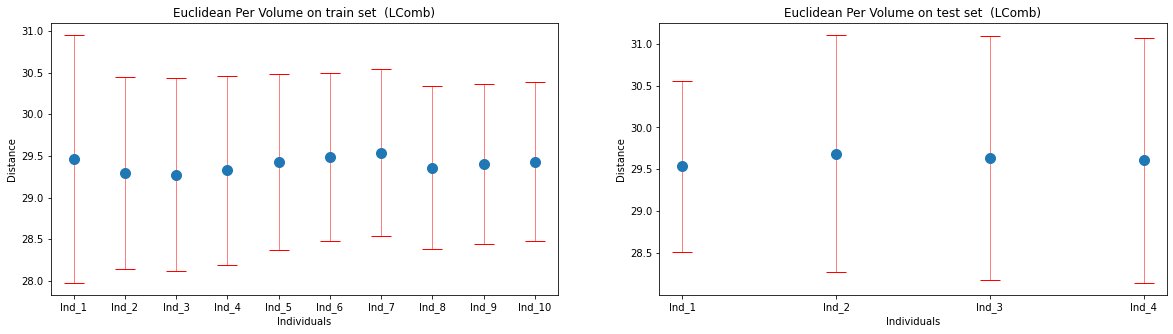

train set mean:  700.4727015904018
train set std:  33.27243325347143
test set mean:  701.2397711617606
test set std:  31.29282826815093


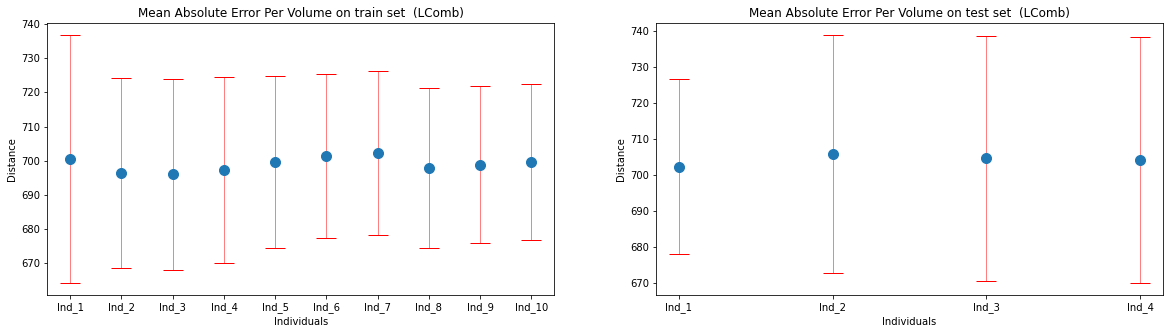

train set mean:  5.001355954578945
train set std:  0.2700415550932983
test set mean:  5.023033125059945
test set std:  0.25175512939779715


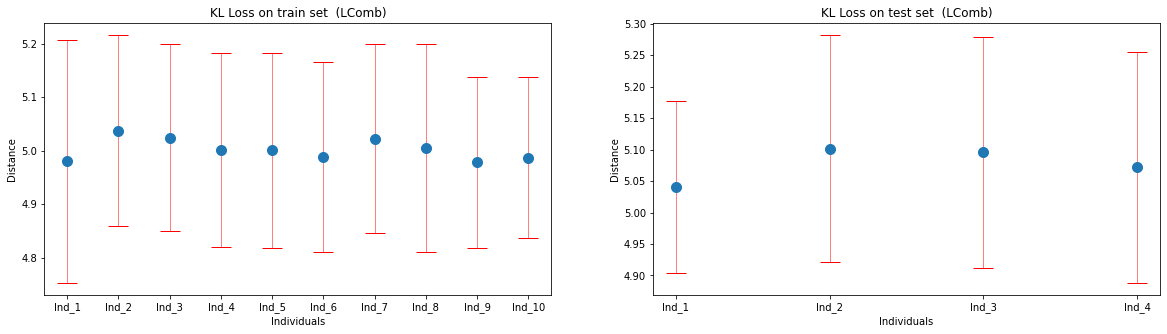

In [8]:
viz.plot_loss_results(eeg_train, bold_train, None, None, eeg_val, bold_val, eeg_network, decoder_network, model_name, n_partitions=n_partitions)

### Try the same hyperparameters, but in an autoencoder training process without the bold branch

In [11]:
importlib.reload(losses)
eeg_network, bold_network, decoder_network = viz.get_models_and_shapes(eeg_file=eeg_file, 
                                                                      bold_file=bold_file, 
                                                                      decoder_file=decoder_file)

eeg_input_shape = (eeg_train.shape[1], eeg_train.shape[2], eeg_train.shape[3], eeg_train.shape[4])
bold_input_shape=(bold_train.shape[1], bold_train.shape[2], bold_train.shape[3])


auto_encoder_model = custom_training.auto_encoder_network(eeg_input_shape, eeg_network, decoder_network)
mode="ae_zeeg_zfmri"
validation_loss = custom_training.autoencoder_training(X_train_eeg, 
                                                    X_train_bold, 
                                                    auto_encoder_model, 
                                                    epochs=5, 
                                                    auto_encoder_optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate), 
                                                    loss_function=losses.get_reconstruction_euclidean_volume_loss,
                                                    batch_size=batch_size, 
                                                    X_val_eeg=eeg_val, 
                                                    X_val_bold=bold_val,
                                                    eeg_train=eeg_train, 
                                                    bold_train=bold_train, 
                                                    eeg_val=eeg_val, 
                                                    bold_val=bold_val,
                                                    X_bold_train_target=X_bold_train_target,
                                                    X_bold_val_target=X_bold_val_target)

model_name = "AE"

Autoencoder Loss:  32.98514 || Validation Autoencoder Loss:  29.714672
Autoencoder Loss:  29.652052 || Validation Autoencoder Loss:  29.506876
Autoencoder Loss:  29.42433 || Validation Autoencoder Loss:  29.49003
Autoencoder Loss:  29.40301 || Validation Autoencoder Loss:  29.490414
Autoencoder Loss:  29.400524 || Validation Autoencoder Loss:  29.48853


train set mean:  -0.03145513624388384
train set std:  0.03070765207502804
validation set mean:  -0.02975539813633077
validation set std:  0.034142044593040155


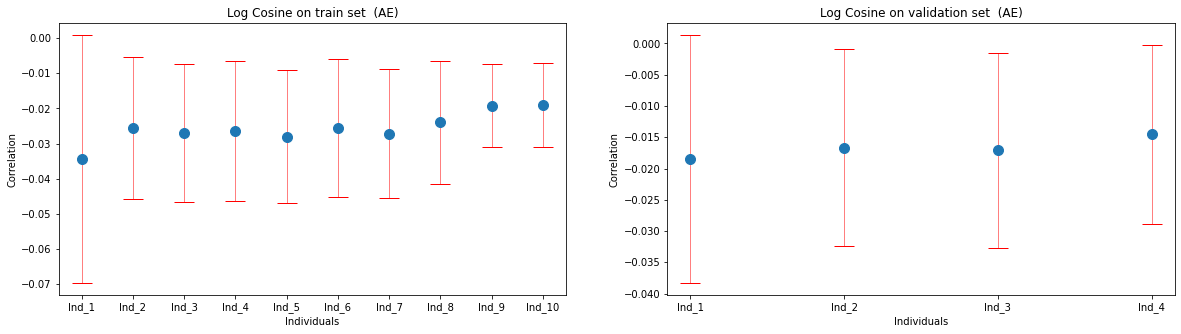

train set mean:  nan
train set std:  nan
validation set mean:  nan
validation set std:  nan


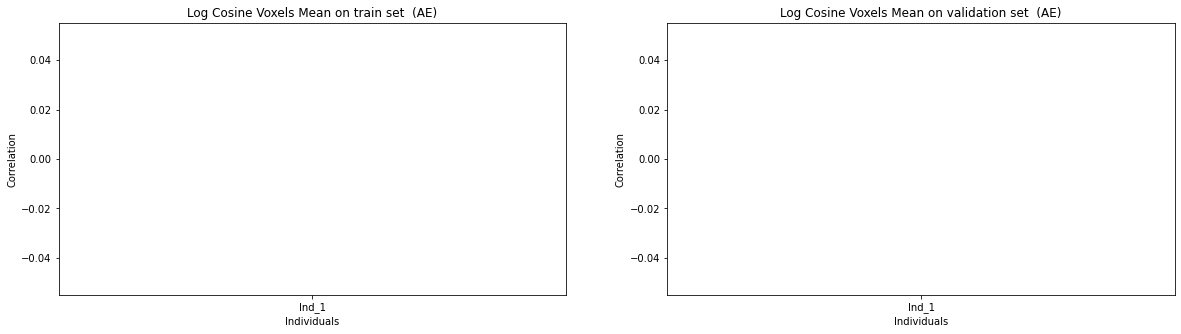

train set mean:  -0.03051788116109882
train set std:  0.028877381144958882
validation set mean:  -0.028769466485495547
validation set std:  0.031581215043277745


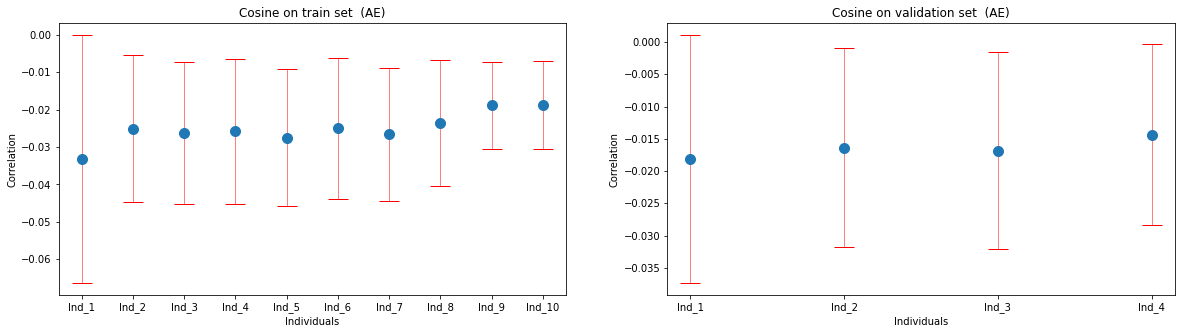

train set mean:  nan
train set std:  nan
validation set mean:  -inf
validation set std:  nan


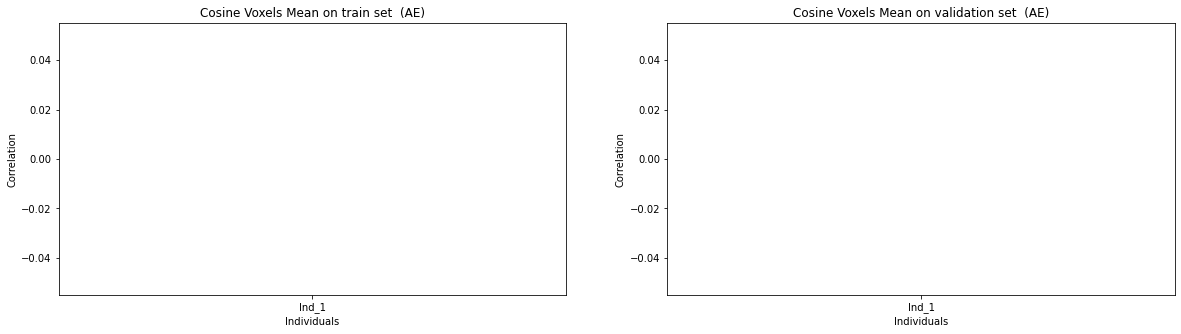

train set mean:  110.48489679609027
train set std:  5.3927392306187585
validation set mean:  110.50004781995501
validation set std:  5.107236112994302


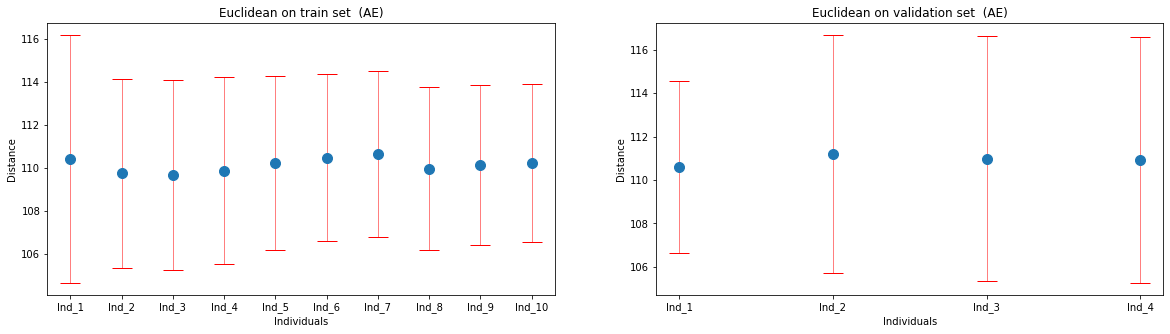

train set mean:  29.48410235813686
train set std:  1.398387460604465
validation set mean:  29.48853131702968
validation set std:  1.3244985224006363


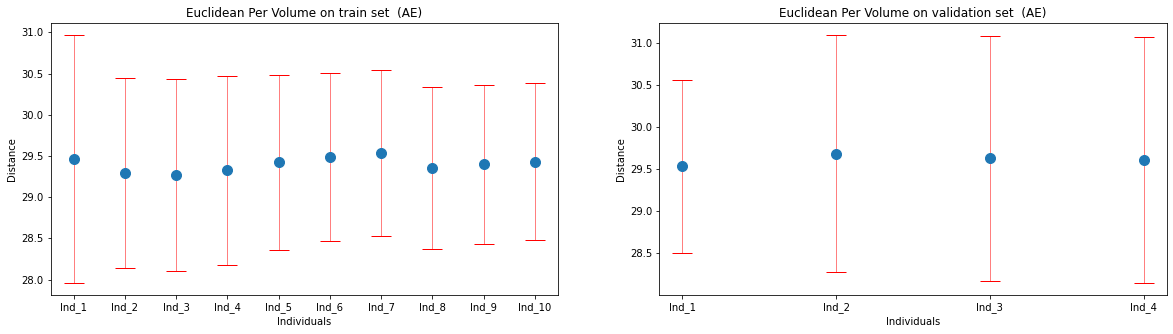

train set mean:  700.4624930245536
train set std:  33.38337068013247
validation set mean:  701.228638785226
validation set std:  31.359828605340986


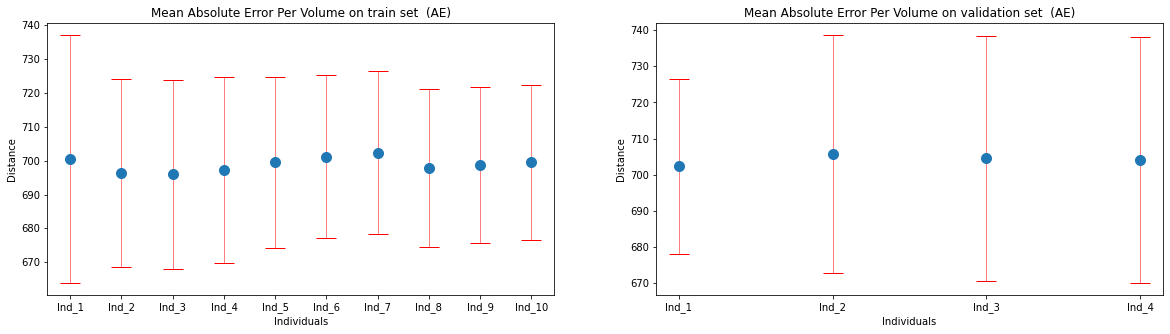

train set mean:  2.1184574101652416
train set std:  0.5596702905695425
validation set mean:  1.716749934213502
validation set std:  0.26652862977086317


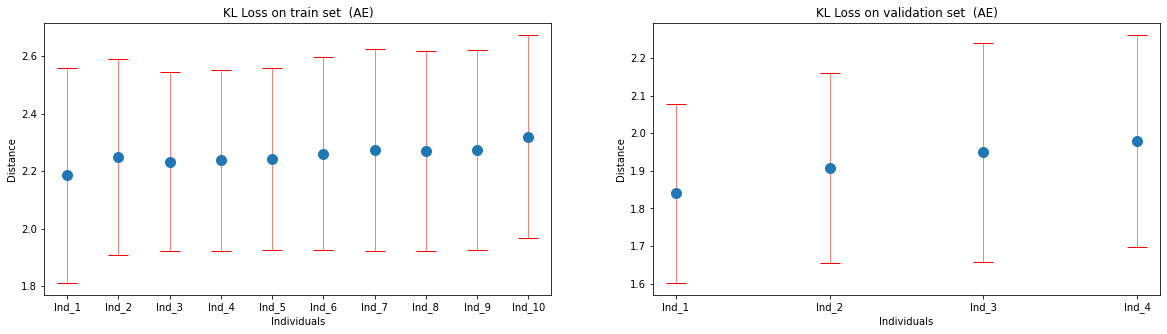

In [12]:
viz.plot_loss_results(eeg_train, bold_train, eeg_val, bold_val, eeg_test, bold_test, eeg_network, decoder_network, model_name, n_partitions=n_partitions)

### Try the same hyperparameters, but in an adversarial training process

In [7]:
import tensorflow as tf
import tensorflow.keras.backend as K


def loss_minmax_discriminator(real_pred, real_true, gen_pred):
    #need to separate positives from negatives

    #log(1) = 0
    positives = np.array([[1., 0., 0.]], dtype='float32').repeat(real_pred.shape[0],0)
    #log(1-1) = 0
    negatives = np.array([[0., 1., 0.]], dtype='float32').repeat(real_pred.shape[0],0)
    for instance in range(real_true.shape[0]):
        if(real_true[instance] == 1.0):
            positives[instance] = real_pred[instance][0].numpy()
        else:
            negatives[instance] = real_pred[instance][0].numpy()

    positives = tf.convert_to_tensor(positives)
    negatives = tf.convert_to_tensor(negatives)
    
    loss = (tf.math.log(positives) + tf.math.log(1. - negatives) + tf.math.log(1. - gen_pred)) / 3.

    return tf.reduce_mean(loss)


def loss_minmax_generator(gen_pred):
    
    return tf.reduce_mean(tf.math.log(gen_pred))

def loss_wasserstein_discriminator(real_pred, real_true, gen_pred):
    #need to separate positives from negatives

    #log(1) = 0
    positives = np.array([[1., 0., 0.]], dtype='float32').repeat(real_pred.shape[0],0)
    #log(1-1) = 0
    negatives = np.array([[0., 1., 0.]], dtype='float32').repeat(real_pred.shape[0],0)
    for instance in range(real_true.shape[0]):
        if(real_true[instance] == 1.0):
            positives[instance] = real_pred[instance][0].numpy()
        else:
            negatives[instance] = real_pred[instance][0].numpy()

    positives = tf.convert_to_tensor(positives)
    negatives = tf.convert_to_tensor(negatives)

    loss = ((tf.constant(np.array([1., 0., 0.]), dtype="float32") - positives) + \
            (tf.constant(np.array([0., 1., 0.]), dtype="float32") - negatives) + \
            (tf.constant(np.array([0., 0., 1.]), dtype="float32") - gen_pred))

    return tf.reduce_mean(loss)


def loss_wasserstein_generator(gen_pred):
    
    return tf.reduce_mean(tf.abs(tf.constant(np.array([1., 0., 0.]), dtype="float32") - gen_pred))

def grad_decoder_adversarial(discriminator, synthesizer, z, eeg, bold, y_pairs, clip=True, clip_value=2, d_loss=losses.loss_minmax_discriminator, g_loss=losses.loss_minmax_generator):
    with tf.GradientTape(watch_accessed_variables=False) as tape:
        
        tape.watch(z)
        tape.watch(synthesizer.variables)

        eeg = tf.convert_to_tensor(eeg)
        bold = tf.convert_to_tensor(bold)
                 
        synthesized = synthesizer(z)

        #pair synthesized with eeg
        real_labels = discriminator([eeg, bold])
        gen_labels = discriminator([eeg, synthesized])
        
        discriminator_loss = d_loss(real_labels, y_pairs, gen_labels)
        synthesizer_loss = g_loss(gen_labels)
        
        if(clip):
            discriminator_loss = tf.clip_by_value(discriminator_loss, -clip_value, clip_value)
            synthesizer_loss = tf.clip_by_value(synthesizer_loss, -clip_value, clip_value)

        return synthesizer_loss, discriminator_loss, tape.gradient(synthesizer_loss, 
                                            synthesizer.trainable_weights)

In [8]:
"""
sensitive_adversarial_training: Adversarial Training

Changing from training the D/G based on the accuracy of G/D given a threshold (0.5)
        
"""
def sensitive_adversarial_training(X_train_eeg, X_train_bold, tr_y, eeg_network, 
    decoder_model, multi_modal_model, epochs=10, 
    discriminator_optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
    generator_optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), 
    g_loss_function=losses.loss_minmax_generator,
    d_loss_function=losses.loss_minmax_discriminator,
    linear_combination=1.0, 
    clip=True,
    clip_value_gradient=0.5, 
    clip_value_loss=2, 
    batch_size=128,
    X_val_eeg=None, X_val_bold=None, tv_y=None, 
    eeg_train=None, bold_train=None, eeg_val=None, bold_val=None,
    X_bold_train_target=None,
    X_bold_val_target=None,
    session=None, verbose=1):


    validation = False
    if(X_val_eeg is not None and X_val_bold is not None and tv_y is not None):
        validation = True

    global_step = tf.Variable(0)
    
    training_d = True
    training_g = False

    _losses = custom_training.custom_training_loss()
    n_epochs = 0

    while(n_epochs < epochs):
        if(training_d):
            print("Training Discriminator")
        elif(training_g):
            print("Training Generator")
        
        decoder_loss = _losses.get_batch_decoder_loss_avg()
        encoder_loss = _losses.get_batch_encoder_loss_avg()
        
        if(training_d and decoder_loss > encoder_loss and encoder_loss != np.inf):
            print("Finished Discriminator\nChanging to Generator")
            training_d = False
            training_g = True
            _losses = custom_training.custom_training_loss()
        elif(training_g and encoder_loss > decoder_loss):
            print("Finished Generator\nChanging to Discriminator")
            training_d = True
            training_g = False
            n_epochs += 1
            _losses = custom_training.custom_training_loss()
        
        for batch_init in range(0, len(X_train_eeg), batch_size):
            batch_start = batch_init
            if(batch_start + batch_size >= len(X_train_eeg)):
                batch_stop = len(X_train_eeg)
            else:
                batch_stop = batch_start + batch_size
            
            shared_eeg = eeg_network(tf.gather_nd(eeg_train, X_train_eeg[batch_start:batch_stop]))
            
            if(training_g):
                # Optimize the synthesizer mode
                decoder_loss, encoder_loss, decoder_grads = grad_decoder_adversarial(multi_modal_model, decoder_model, 
                                                                        shared_eeg,
                                                                        tf.gather_nd(eeg_train, X_train_eeg[batch_start:batch_stop]), 
                                                                        tf.gather_nd(bold_train, X_train_bold[batch_start:batch_stop]), 
                                                                        tr_y[batch_start:batch_stop],
                                                                        d_loss=d_loss_function,
                                                                        g_loss=g_loss_function,
                                                                        clip=clip,
                                                                        clip_value=clip_value_loss)
                with tf.name_scope("gradient_decoder") as scope:
                    generator_optimizer.apply_gradients(zip(decoder_grads, decoder_model.trainable_variables), name=scope)
                
            elif(training_d):
                #now train the compression by correlation model
                encoder_loss, decoder_loss, encoder_grads = custom_training.grad_multi_encoder_adversarial(multi_modal_model, decoder_model, 
                                                                        shared_eeg,
                                                                        tf.gather_nd(eeg_train, X_train_eeg[batch_start:batch_stop]), 
                                                                        tf.gather_nd(bold_train, X_train_bold[batch_start:batch_stop]), 
                                                                        tr_y[batch_start:batch_stop],
                                                                        d_loss=d_loss_function,
                                                                        g_loss=g_loss_function,
                                                                        clip=clip,
                                                                        clip_value=clip_value_loss)
                
                with tf.name_scope("gradient_encoders") as scope:
                    if(clip):
                        encoder_clipped_grads = ()
                        for grad in encoder_grads:
                            encoder_clipped_grads += (tf.clip_by_value(grad, clip_value_min=-clip_value_gradient, clip_value_max=clip_value_gradient), )
                        encoder_grads=encoder_clipped_grads
                        
                    discriminator_optimizer.apply_gradients(zip(encoder_grads, multi_modal_model.trainable_variables), name=scope)
                
            # Track progress
            _losses.update_batch_decoder_loss_avg(decoder_loss)
            _losses.update_batch_encoder_loss_avg(encoder_loss)

        # end epoch
        decoder_loss = _losses.get_batch_decoder_loss_avg()
        encoder_loss = _losses.get_batch_encoder_loss_avg()

        #get validation analyses
        #get validation analyses
        shared_eeg_train = eeg_network(tf.gather_nd(eeg_train, X_train_eeg))
        shared_eeg_val = eeg_network(tf.gather_nd(eeg_val, X_val_eeg))
        train_reconstruction_loss = losses.get_reconstruction_log_cosine_loss(decoder_model(shared_eeg_train), tf.gather_nd(bold_train, X_train_bold))
        val_reconstruction_loss = losses.get_reconstruction_log_cosine_loss(decoder_model(shared_eeg_val), tf.gather_nd(bold_val, X_val_bold))
        
        if(verbose):
            print("GAN Encoder Loss: ", tf.keras.backend.eval(encoder_loss), 
                " || GAN Decoder Loss: ", tf.keras.backend.eval(decoder_loss),
                " || Train Reconstruction Loss: ", tf.keras.backend.eval(train_reconstruction_loss),
                " || Validation Reconstruction Loss: ", tf.keras.backend.eval(val_reconstruction_loss))
            sys.stdout.flush()

    shared_eeg_val = eeg_network(tf.gather_nd(eeg_val, X_val_eeg))
    return tf.keras.backend.eval(custom_training.loss_decoder(decoder_model(shared_eeg_val), tf.gather_nd(bold_val, X_val_bold)))

In [9]:
import importlib
importlib.reload(custom_training)
importlib.reload(losses)

eeg_network, bold_network, decoder_network = viz.get_models_and_shapes(eeg_file=eeg_file, 
                                                                      bold_file=bold_file, 
                                                                      decoder_file=decoder_file)

eeg_input_shape = (eeg_train.shape[1], eeg_train.shape[2], eeg_train.shape[3], eeg_train.shape[4])
bold_input_shape=(bold_train.shape[1], bold_train.shape[2], bold_train.shape[3])

multi_modal_model = custom_training.multi_modal_network(eeg_input_shape, bold_input_shape, eeg_network, bold_network, 
                                                        dcca=False, 
                                                        lstm=True,
                                                        corr_distance=False,
                                                        dist_function=losses.correlation,
                                                        gan=True,
                                                        gan_activation="sigmoid",
                                                        gan_output_dimension=1)
mode="gan_lstm_zeeg_zfmri"
validation_loss = custom_training.adversarial_training(X_train_eeg, 
                                       X_train_bold, 
                                       tr_y, 
                                       eeg_network, decoder_network, multi_modal_model, 
                                       epochs=5, 
                                       discriminator_optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate), 
                                       generator_optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate), 
                                       batch_size=batch_size, 
                                       g_loss_function=loss_minmax_generator,
                                       d_loss_function=loss_minmax_discriminator,
                                       linear_combination=loss_coefficient, 
                                       clip=True,
                                       clip_value_gradient=25.0,
                                        clip_value_loss=20.0, 
                                       X_val_eeg=X_val_eeg, 
                                       X_val_bold=X_val_bold, 
                                       tv_y=tv_y,
                                       eeg_train=eeg_train, 
                                       bold_train=bold_train, 
                                       eeg_val=eeg_val, 
                                       bold_val=bold_val,
                                       X_bold_train_target=X_bold_train_target,
                                       X_bold_val_target=X_bold_val_target)

model_name = "GAN"

GAN Encoder Loss:  -10.0  || GAN Decoder Loss:  -0.40407607  || GAN Validation Decoder Loss:  -0.018696189  || Train Reconstruction Loss:  -0.02867783  || Validation Reconstruction Loss:  -0.018696189


ResourceExhaustedError: OOM when allocating tensor with shape[1400,40,70,14,1] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc [Op:Conv3D]

In [ ]:
viz.plot_loss_results(eeg_train, bold_train, eeg_val, bold_val, eeg_test, bold_test, eeg_network, decoder_network, model_name, n_partitions=n_partitions)

### Try to check if alternate training between LComb and GAN training

In [110]:
#eeg_network, bold_network, decoder_network = get_models_and_shapes()

multi_modal_model = custom_training.multi_modal_network(eeg_input_shape, bold_input_shape, eeg_network, bold_network, dcca=False)


validation_loss = custom_training.linear_combination_training(X_train_eeg, 
                                                            X_train_bold, 
                                                            tr_y, 
                                                            eeg_network, 
                                                            decoder_network, 
                                                            multi_modal_model, 
                                                            epochs=5, 
                                                            encoder_optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
                                                            decoder_optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
                                                            batch_size=batch_size, 
                                                            linear_combination=loss_coefficient,
                                                            X_val_eeg=X_val_eeg,
                                                            X_val_bold=X_val_bold,
                                                            tv_y=tv_y)

multi_modal_model = custom_training.multi_modal_network(eeg_input_shape, bold_input_shape, eeg_network, bold_network, dcca=False, corr_distance=True)

validation_loss = custom_training.adversarial_training(X_train_eeg, 
                                                       X_train_bold, 
                                                       tr_y, 
                                                       eeg_network, decoder_network, multi_modal_model, 
                                                       epochs=5, 
                                                       discriminator_optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate), 
                                                       generator_optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate), 
                                                       batch_size=batch_size, 
                                                       linear_combination=loss_coefficient, 
                                                       X_val_eeg=X_val_eeg, 
                                                       X_val_bold=X_val_bold, 
                                                       tv_y=tv_y)

ValueError: Attempt to convert a value (None) with an unsupported type (<class 'NoneType'>) to a Tensor.

train set mean:  -0.13035505447935844
train set std:  0.10439693812962365
validation set mean:  -0.2702327285494123
validation set std:  0.007279591704164774
test set mean:  -0.2692250900325321
test set std:  0.013276322805917784


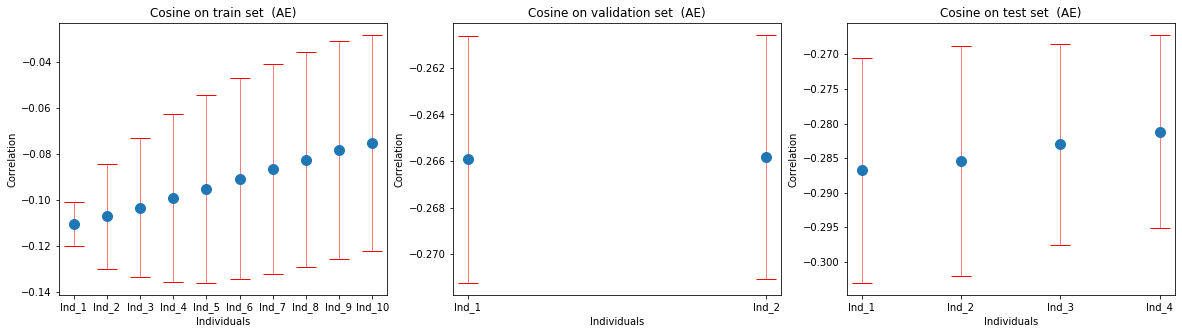

train set mean:  217.21822008405414
train set std:  33.241409173264245
validation set mean:  1998.391369047619
validation set std:  2.57665969646488
test set mean:  1995.119361514137
test set std:  6.124074982564129


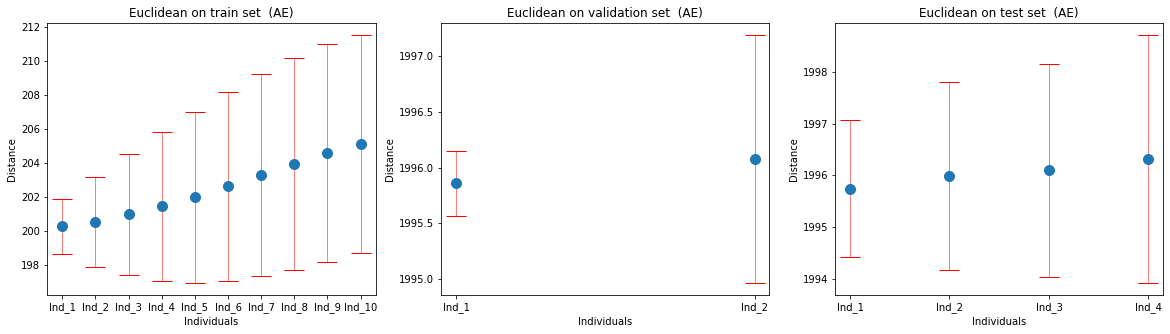

In [31]:
viz.plot_loss_results(eeg_train, bold_train, eeg_val, bold_val, eeg_test, bold_test, eeg_network, decoder_network, model_name, n_partitions=n_partitions)

### Top-K ranking synthesis

In [10]:
eeg_network, bold_network, decoder_network = viz.get_models_and_shapes(eeg_file=eeg_file, 
                                                                      bold_file=bold_file, 
                                                                      decoder_file=decoder_file)

multi_modal_model = custom_training.multi_modal_network(eeg_input_shape, bold_input_shape, eeg_network, bold_network, 
                                                        corr_distance=True,
                                                        dist_function=losses.euclidean,#mean_volume_abs/euclidean /kl_loss
                                                        lstm=True,
                                                        gan=False,
                                                        gan_activation="softmax",
                                                        gan_output_dimension=1)


validation_loss = custom_training.ranked_synthesis_training(X_train_eeg, 
                                                            X_train_bold, 
                                                            tr_y, 
                                                            eeg_network, 
                                                            decoder_network, 
                                                            multi_modal_model, 
                                                            bold_network=bold_network, 
                                                            epochs=5, 
                                                            encoder_optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
                                                            decoder_optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
                                                            loss_function=losses.get_reconstruction_euclidean_volume_loss,
                                                            batch_size=batch_size, 
                                                            top_k=5, 
                                                            eeg_train=eeg_train, 
                                                            bold_train=bold_train, 
                                                            eeg_val=eeg_val, 
                                                            bold_val=bold_val,
                                                            X_val_eeg=X_val_eeg,
                                                            X_val_bold=X_val_bold,
                                                            tv_y=tv_y)

model_name="Top-5"


#1 - 
#2 - 
#3 - 
#4 - 
#5 - 
#6 - 
#7 - 
#8 - 
#9 - 
#10 - 

Encoder Loss:  0.8831492
Encoder Loss:  0.1917867
Encoder Loss:  0.15505628
Encoder Loss:  0.1684991
Encoder Loss:  0.15245365
Decoder Loss:  40.478546 Validation Decoder Loss:  38.111206
Decoder Loss:  37.01872 Validation Decoder Loss:  34.993145
Decoder Loss:  34.08452 Validation Decoder Loss:  32.499275
Decoder Loss:  31.818977 Validation Decoder Loss:  30.753494
Decoder Loss:  30.323748 Validation Decoder Loss:  29.790257


train set mean:  -0.03825754704261531
train set std:  0.03587284930338877
validation set mean:  -0.03077103699615691
validation set std:  0.034480254473585444


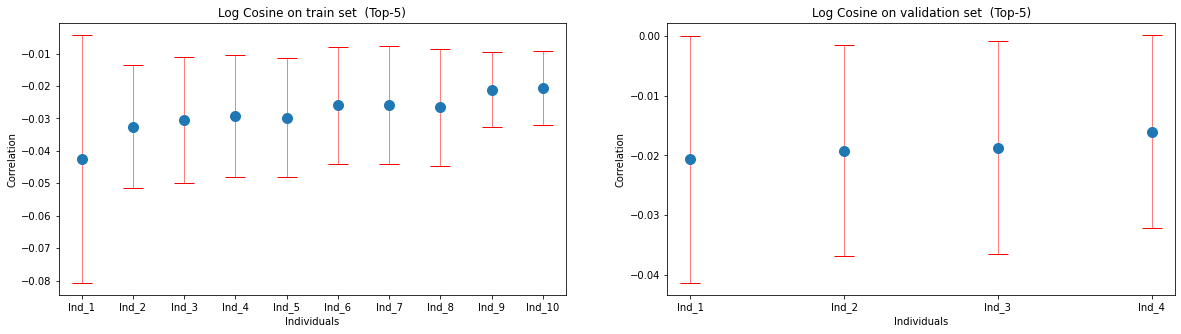

train set mean:  nan
train set std:  nan
validation set mean:  nan
validation set std:  nan


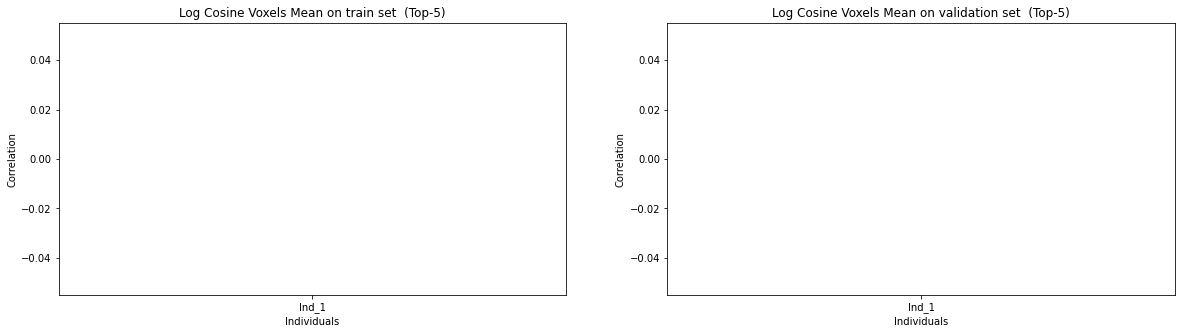

train set mean:  -0.03692933829094857
train set std:  0.03341125292741284
validation set mean:  -0.029744473651849797
validation set std:  0.03186518698617185


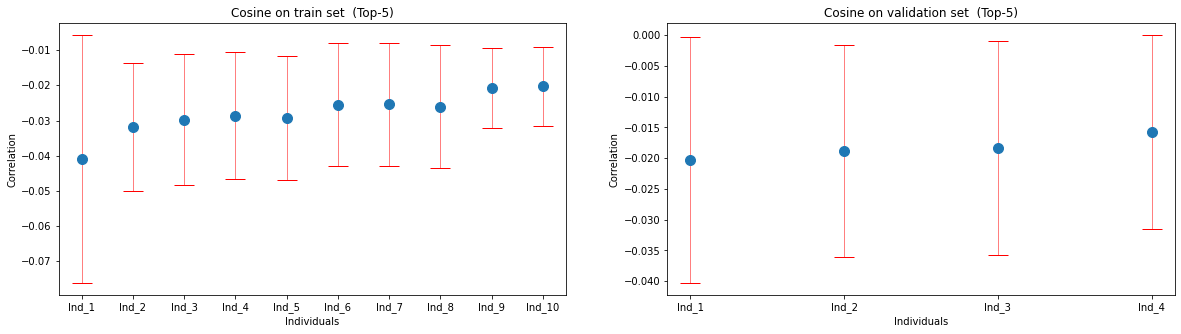

train set mean:  nan
train set std:  nan
validation set mean:  -inf
validation set std:  nan


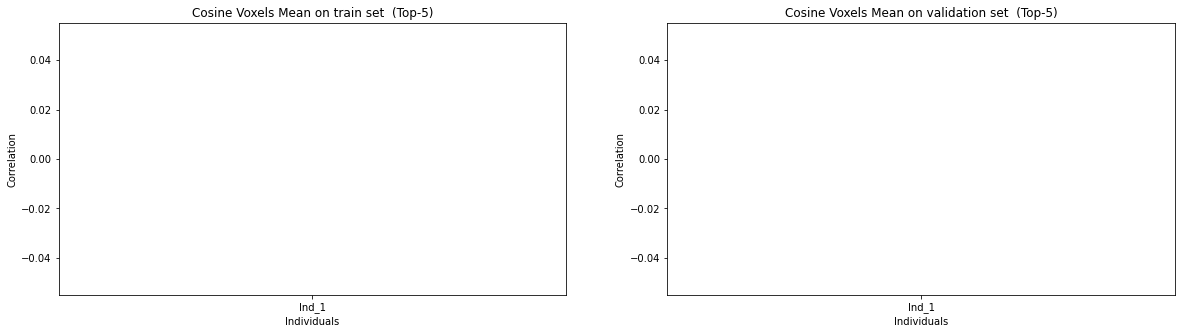

train set mean:  112.03177021571568
train set std:  5.647741986676956
validation set mean:  111.91631957462856
validation set std:  5.242831404458677


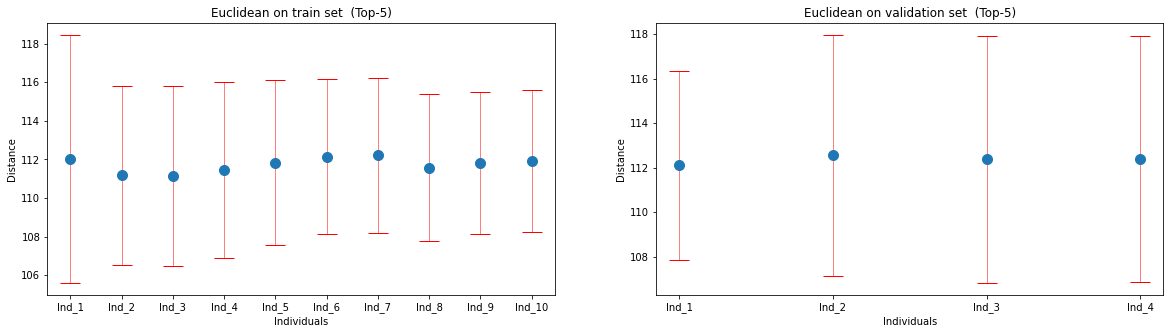

train set mean:  29.896671608516147
train set std:  1.4647715486157533
validation set mean:  29.868350982666016
validation set std:  1.3612169184831207


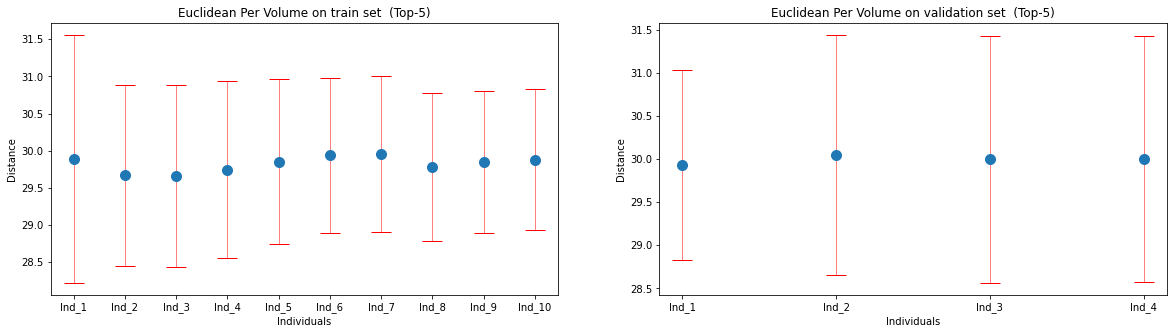

train set mean:  710.4933646065848
train set std:  35.08598480753384
validation set mean:  710.31008039202
validation set std:  32.263567486034574


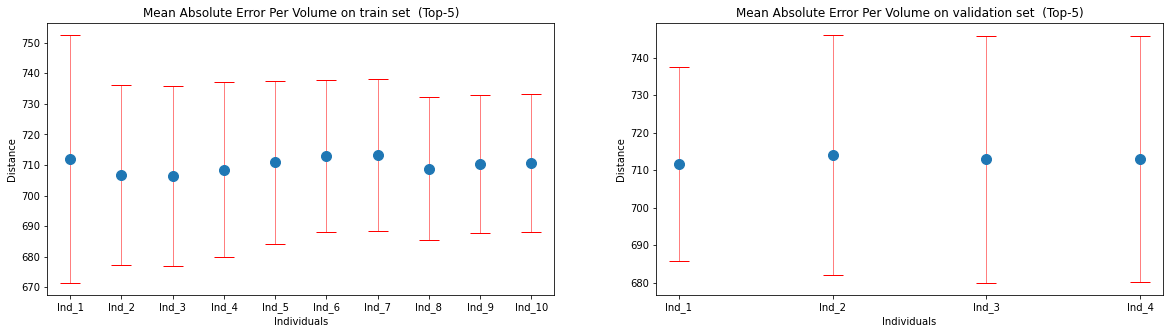

train set mean:  0.47237849938017984
train set std:  0.03455416950415805
validation set mean:  0.4833798663956778
validation set std:  0.030311950274738743


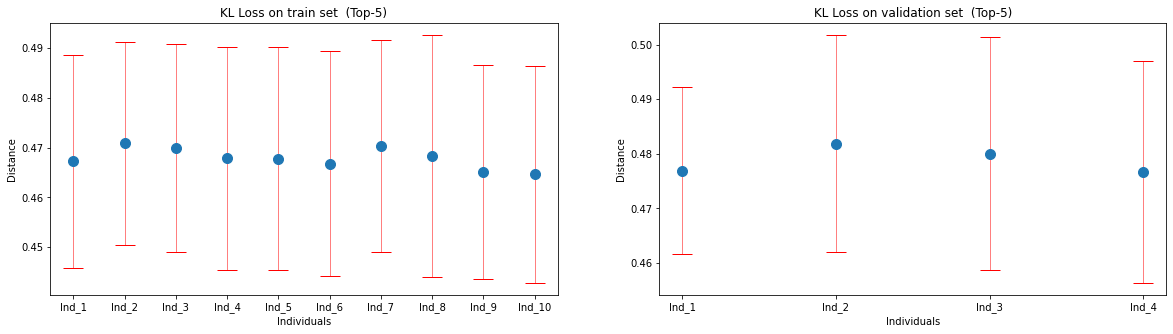

In [11]:
viz.plot_loss_results(eeg_train, bold_train, eeg_val, bold_val, eeg_test, bold_test, eeg_network, decoder_network, model_name, n_partitions=n_partitions)